# Sampling Test


One of the most amazing advantage of using MelGAN is "it works realtime on CPU!".

Try it!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import IPython.display as ipd
import tqdm

import torch

import models
from torch.utils.data import DataLoader
from data import LJspeechDataset, collate_fn, collate_fn_synthesize

import commons

import librosa
import numpy as np
import os
import json

import glob
def latest_checkpoint_path(dir_path):
  f_list = glob.glob(os.path.join(dir_path, "G_*.pth"))
  f_list.sort(key=lambda f: int("".join(filter(str.isdigit, f))))
  x = f_list[-1]
  print(x)
  return x

In [2]:
kwargs = {'num_workers': 0, 'pin_memory': True}
train_dataset = LJspeechDataset('./DATASETS/ljspeech/', True, 0.1)
test_dataset = LJspeechDataset('./DATASETS/ljspeech/', False, 0.1)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn,
                          **kwargs)
test_loader = DataLoader(test_dataset, batch_size=1, collate_fn=collate_fn_synthesize,
                          **kwargs)

model_dir = "./logs/nci_020/"
configs = json.load(open(os.path.join(model_dir, "config.json"), "r"))

model = models.Generator(configs["data"]["n_channels"], noise=configs["model"]["noise"])#.to("cuda")

In [3]:
checkpoint_path = latest_checkpoint_path(model_dir)
checkpoint_dict = torch.load(checkpoint_path, map_location='cpu')
state_dict = checkpoint_dict['model']
new_state_dict= {}
for k, v in model.state_dict().items():
    try:
        new_state_dict[k] = state_dict[k]
    except:
        print("%s is not in the checkpoint" % k)
        new_state_dict[k] = v
model.load_state_dict(new_state_dict)
model.remove_weight_norm()

./logs/nci_020/G_11.pth


In [4]:
idx_stop = 0
for i, (x, c, _) in enumerate(test_loader):
    #x, c = x.to("cuda"), c.to("cuda")
    if i == idx_stop:
        break
ipd.Audio(x.cpu().numpy().reshape(-1), rate=22050)

In [5]:
with torch.no_grad():
    x_hat = model(c)
    if configs["data"]["mu_law"]:
      x_hat = commons.mu_law(x_hat, inversion=True)
ipd.Audio(x_hat.cpu().detach().numpy().reshape(-1), rate=22050)

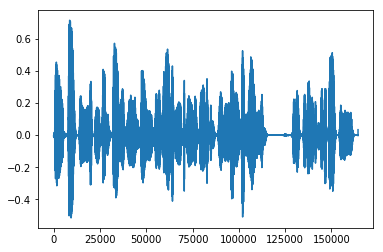

In [6]:
plt.plot(x_hat.cpu().detach().numpy().reshape(-1))

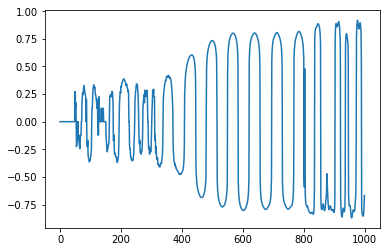

In [7]:
plt.plot(commons.mu_law(x).cpu().detach().numpy().reshape(-1)[:1000])

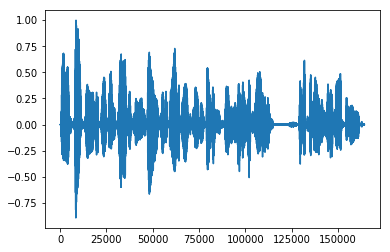

In [10]:
plt.plot(x.cpu().detach().numpy().reshape(-1))